In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [35]:
DATA_DIR = '../../data'
data_file = f'{DATA_DIR}/nyse_historic.csv'

In [36]:
data = pd.read_csv(data_file, 
                   usecols=['Date', 'Adj Close'], 
                   parse_dates=True, 
                   index_col='Date')
data = data.rename(columns={'Adj Close': 'Close'})
data.head()

,Close
Date,
1965-12-31,528.690002
1966-01-03,527.210022
1966-01-04,527.840027
1966-01-05,531.119995
1966-01-06,532.070007


In [37]:
print(np.isnan(data.Close).sum())
data.fillna(method='ffill', inplace=True)
print(np.isnan(data.Close).sum())

1
0


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13365 entries, 1965-12-31 to 2019-02-05
Data columns (total 1 columns):
Close    13365 non-null float64
dtypes: float64(1)
memory usage: 208.8 KB


In [39]:
data.describe()

,Close
count,13365.000000
mean,4066.920669
std,3701.595629
min,347.769989
25%,640.659973
50%,2422.229980
75%,6939.430176
max,13637.019531


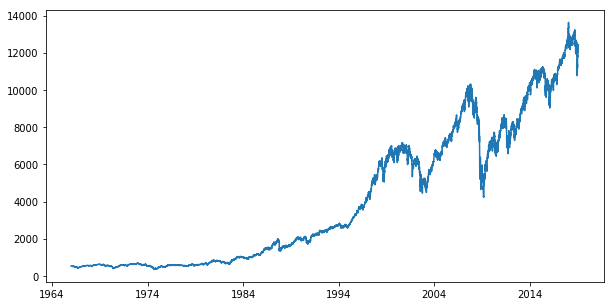

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(data);

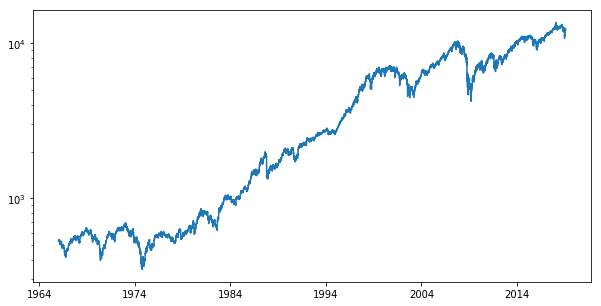

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(data)
plt.yscale('log');

In [42]:
data['PctChange'] = data.pct_change()
data.head()

,Close,PctChange
Date,,
1965-12-31,528.690002,NaN
1966-01-03,527.210022,-0.002799
1966-01-04,527.840027,0.001195
1966-01-05,531.119995,0.006214
1966-01-06,532.070007,0.001789


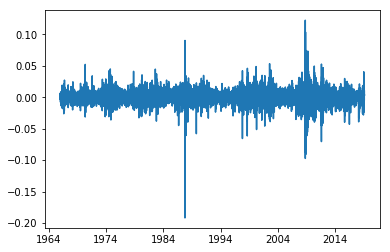

In [43]:
plt.plot(data.PctChange);

In [44]:
data['LogReturns'] = np.log(1 + data.PctChange)

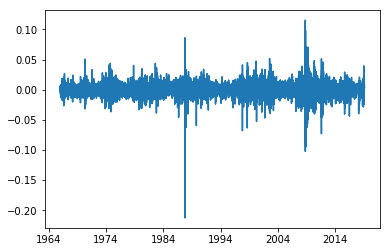

In [45]:
plt.plot(data.LogReturns);

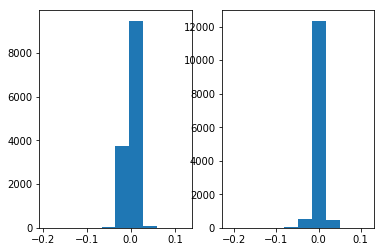

In [46]:
plt.subplot(121)
plt.hist(data.PctChange[1:])
plt.subplot(122)
plt.hist(data.LogReturns[1:]);

In [47]:
data = data.iloc[1:, :] # drop init NA row

In [48]:
data = pd.DataFrame(data['LogReturns'])
data.tail()

,LogReturns
Date,
2019-01-30,0.010826
2019-01-31,0.006251
2019-02-01,0.002490
2019-02-04,0.004220
2019-02-05,0.003743


In [49]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [17]:
train_len = int(len(data_scaled) * 0.7)
test_len = len(data_scaled) - train_len
train_data = data_scaled[0:train_len, :]
test_data = data_scaled[train_len:len(data_scaled), :]
print(len(train_data), len(test_data))

9354 4010


In [18]:
def create_dataset(dataset, t_step=1):
    X, y = [], []
    for i in range(len(dataset) - t_step - 1):
        a = dataset[i:(i + t_step), 0]
        X.append(a)
        y.append(dataset[i + t_step, 0])
    return np.array(X), np.array(y)

In [19]:
TIME_STEP = 1
LSTM_SIZE = 256
EPOCHS = 20
BATCH = 1

In [20]:
X_train, y_train = create_dataset(train_data, TIME_STEP)
X_test, y_test = create_dataset(test_data, TIME_STEP)

In [21]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test  = np.reshape(X_test,  (X_test.shape[0],  1, X_test.shape[1]))

In [22]:
mod = Sequential()
mod.add(LSTM(LSTM_SIZE, input_shape=(1, TIME_STEP)))
mod.add(Dense(1, activation='sigmoid'))
mod.compile(loss='mse', optimizer='adam', metrics=['mse'])
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = mod.fit(
    X_train, y_train, epochs=EPOCHS, batch_size=BATCH, verbose=1)

Epoch 1/20
9352/9352 [==============================] - 42s 5ms/step - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 2/20
9352/9352 [==============================] - 44s 5ms/step - loss: 2.3444e-04 - mean_squared_error: 2.3444e-04
Epoch 3/20
9352/9352 [==============================] - 42s 5ms/step - loss: 2.2099e-04 - mean_squared_error: 2.2099e-04
Epoch 4/20
9352/9352 [==============================] - 45s 5ms/step - loss: 2.0287e-04 - mean_squared_error: 2.0287e-04
Epoch 5/20
9352/9352 [==============================] - 43s 5ms/step - loss: 7.4488e-05 - mean_squared_error: 7.4488e-05
Epoch 6/20
9352/9352 [==============================] - 45s 5ms/step - loss: 3.3982e-05 - mean_squared_error: 3.3982e-05
Epoch 7/20
9352/9352 [==============================] - 45s 5ms/step - loss: 2.1273e-05 - mean_squared_error: 2.1273e-05
Epoch 8/20
9352/9352 [==============================] - 45s 5ms/step - loss: 1.5363e-05 - mean_squared_error: 1.5363e-05
Epoch 9/20
9352/9352 [==================

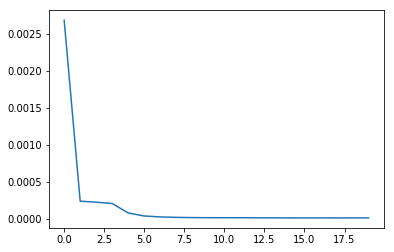

In [24]:
plt.plot(history.history['mean_squared_error']);

In [25]:
score = mod.evaluate(X_train, y_train, verbose=0)
print(f'Loss: {score[0]}\nAcc: {score[1]}')

Loss: 6.233514050122694e-06
Acc: 6.233514050122694e-06


In [26]:
train_pred = mod.predict(X_train)
test_pred  = mod.predict(X_test)

In [50]:
print(train_pred.shape)
train_pred

(9352, 1)


array([[0.01328042],
       [0.01332134],
       [0.01353549],
       ...,
       [0.32701054],
       [0.32259372],
       [0.32553464]], dtype=float32)

In [52]:
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform([y_train])
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform([y_test])

In [53]:
train_pred_plot = np.empty_like(data_scaled)
train_pred_plot[:, :] = np.nan
train_pred_plot[1:len(train_pred) + 1, :] = train_pred

test_pred_plot = np.empty_like(data_scaled)
test_pred_plot[:, :] = np.nan
test_pred_plot[len(train_pred) + 2 + 1:len(data_scaled) - 1, :] = test_pred

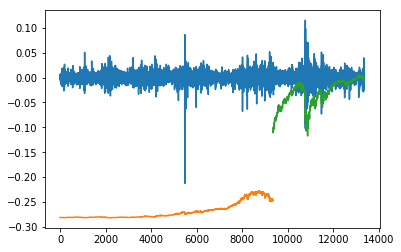

In [54]:
plt.plot(scaler.inverse_transform(data_scaled))
plt.plot(train_pred_plot)
plt.plot(test_pred_plot);